In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

In [2]:
def model_validation(ytrue, y_pred):
    '''Definition for computing and printing a series of Classification metric scores'''
    print(f'Accuracy Score: {metrics.accuracy_score(ytrue, y_pred)}')
    print(f'Precision Score: {metrics.precision_score(ytrue, y_pred, average="macro")}')
    print(f'Recall Score: {metrics.recall_score(ytrue, y_pred, average="macro")}')
    print(f'F1 Score: {metrics.f1_score(ytrue, y_pred, average="macro")}')

## Red Wine Dataset

We'll read in our red wine dataset and add three random variables to help us choose the most relevant parameters to use for our prediction.

The random values that we'll add are:
* random binary (e.g., 0 and 1)
* random uniform (e.g., float values between 0 and 1)
* random integers (e.g., random integer values between -1000 and 1000)

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

np.random.seed(1000)
df['rand_binary'] = np.random.randint(2, size=df.shape[0])
df['rand_uniform'] = np.random.random_sample(size=df.shape[0])
df['rand_integer'] = np.random.randint(-1000, 1001, size=df.shape[0])

## Correlation of Features to Target

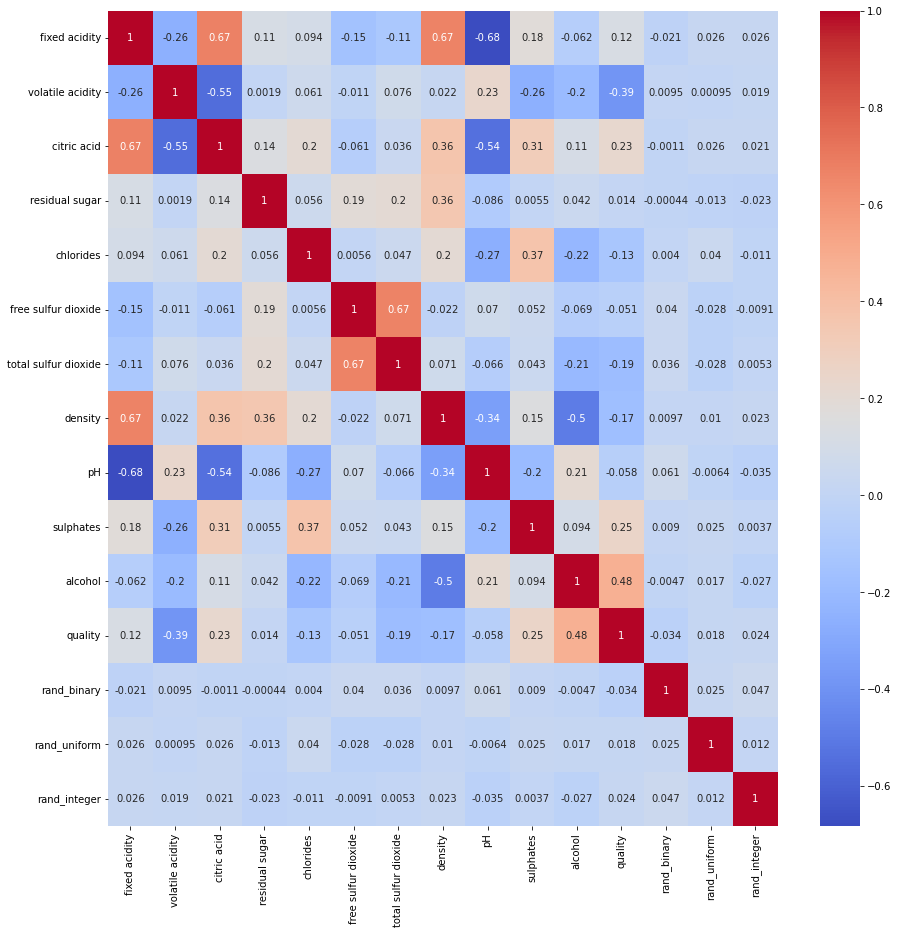

In [4]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.coolwarm)
plt.show()

We could just pick those feature variables that are more highly correlated than our random variables to reduce the total number of features and attempt to avoid overfitting our model.

Or we can use all of our variables, including the random variables and have an initial model tell us about the importance of each variable and only choose those that are of greater importance than any of our random variables.

In [5]:
# Use all of our features
features = df.drop(columns=['quality'])
target = df['quality']

# Split our data into training and testing datasets
xtrain, xtest, ytrain, ytrue = train_test_split(features, target, random_state=2)

# Oversample our imbalanced data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)

# Use a decision tree to create an initial model
model = DecisionTreeClassifier(random_state=4)
model.fit(X_resampled, y_resampled)

# List the important features
important_index = np.argsort(model.feature_importances_)[::-1]
for index in important_index:
    print(f'{model.feature_names_in_[index]}: {model.feature_importances_[index]:.4f}')

alcohol: 0.1664
volatile acidity: 0.1437
sulphates: 0.1300
chlorides: 0.0885
total sulfur dioxide: 0.0795
pH: 0.0644
free sulfur dioxide: 0.0583
rand_integer: 0.0573
residual sugar: 0.0553
rand_uniform: 0.0492
citric acid: 0.0424
density: 0.0360
fixed acidity: 0.0202
rand_binary: 0.0087


### Create Base Model
Use only the most important features and create a simple decision tree classifier.

In [6]:
features = df[model.feature_names_in_[important_index[:7]]]
target = df['quality']

xtrain, xtest, ytrain, ytrue = train_test_split(features, target, random_state=2)

X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)

model = DecisionTreeClassifier(random_state=4)

model.fit(X_resampled, y_resampled)

y_pred = model.predict(xtest)

model_validation(ytrue, y_pred)

Accuracy Score: 0.6
Precision Score: 0.33233386607370347
Recall Score: 0.3361298798798799
F1 Score: 0.3333376437843297


Now let's make a pipeline to scale our data to not make big value features more important and see if that improves our model.

In [7]:
pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=4))

pipeline.fit(X_resampled, y_resampled)

y_pred = pipeline.predict(xtest)

model_validation(ytrue, y_pred)

Accuracy Score: 0.605
Precision Score: 0.3420717142939365
Recall Score: 0.338156906906907
F1 Score: 0.3387153507744424


## Random Forecast (Ensemble - Bagging)

Now let's implement an ensemble technique (bagging) by creating a Random Forecast model. We'll set the max number of features based on the number being used in our prediction and continuing to use the oversampled data.

In [8]:
# Set parameter for max number of features for Random Forest
m = np.int64(np.sqrt(features.shape[1]))

# Set up our Random Forest
random_forest = RandomForestClassifier(max_features=m, max_samples=0.75, oob_score=True, random_state=4)
random_forest.fit(X_resampled, y_resampled)

y_pred = random_forest.predict(xtest)

model_validation(ytrue, y_pred)

random_forest.feature_names_in_

Accuracy Score: 0.635
Precision Score: 0.3499518650067568
Recall Score: 0.3601539039039039
F1 Score: 0.35347038831991323


/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['alcohol', 'volatile acidity', 'sulphates', 'chlorides',
       'total sulfur dioxide', 'pH', 'free sulfur dioxide'], dtype=object)

What about it we weighted our features instead of using the over sampled data?

In [9]:
classes = np.unique(ytrain)
cw = class_weight.compute_class_weight('balanced', classes=classes, y=ytrain)
weights = dict(zip(classes, cw))

random_forest = RandomForestClassifier(max_features=m, class_weight=weights)
random_forest.fit(xtrain, ytrain)

y_pred = random_forest.predict(xtest)

model_validation(ytrue, y_pred)

Accuracy Score: 0.65
Precision Score: 0.4038866834919466
Recall Score: 0.3514827327327328
F1 Score: 0.36485864109800065


## Random Forecast - Boosting

Now let's try a different ensemble technique using the AdaBoost method to use weak learners to enhance the prediction.

In [10]:
adaboost = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_features=m, max_samples=.75, random_state=4),
                              learning_rate=.1, n_estimators=25, random_state=1)

adaboost.fit(xtrain, ytrain)

y_pred = adaboost.predict(xtest)

model_validation(ytrue, y_pred)

Accuracy Score: 0.655
Precision Score: 0.49893434987748825
Recall Score: 0.35775150150150153
F1 Score: 0.3809171331812842


/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Credit Card Fraud Prediction with Gradient Boosting

Let's try our hand at another type of prediction using our highly imbalanced credit card fraud data set and using a Boosting technique.

Here we'll first 

In [11]:
# load the data set
data = pd.read_csv('http://bergeron.valpo.edu/creditcard.csv')

# normalise the amount column
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
 
# drop Time and Amount columns as they are not relevant for prediction purpose
data = data.drop(['Time', 'Amount'], axis = 1)

X = data.drop(columns=['Class'])
y = data['Class']

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [12]:
gboost_tree = HistGradientBoostingClassifier(learning_rate=.01, random_state=0)

gboost_tree.fit(X_train, y_train)

y_pred = gboost_tree.predict(X_test)

model_validation(y_test, y_pred)
# print classification report
print(metrics.classification_report(y_test, y_pred))

Accuracy Score: 0.9993562960102056
Precision Score: 0.9626875777165811
Recall Score: 0.8400891589049801
F1 Score: 0.891995696251319
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.93      0.68      0.78       147

    accuracy                           1.00     85443
   macro avg       0.96      0.84      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [13]:
sm = SMOTE(sampling_strategy='minority', random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

gboost_tree.fit(X_train_res, y_train_res)

y_pred = gboost_tree.predict(X_test)

model_validation(y_test, y_pred)
# print classification report
print(metrics.classification_report(y_test, y_pred))

Accuracy Score: 0.9910232552695949
Precision Score: 0.5733559875697779
Recall Score: 0.9343849174447494
F1 Score: 0.6235959301586763
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.15      0.88      0.25       147

    accuracy                           0.99     85443
   macro avg       0.57      0.93      0.62     85443
weighted avg       1.00      0.99      0.99     85443



## Regression - Bagging

Let's take a brief look at using an ensemble technique (bagging) for a regression problem and scale our data.

In [14]:
df_petrol = pd.read_csv('https://raw.githubusercontent.com/kgoebber/data_151/main/notebooks/petrol_consumption.csv')

Unscaled data and the Stochastic Gradient Descent Regression

In [15]:
x_unscaled = df_petrol[['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)']]

X_train, X_test, y_train, ytrue = train_test_split(x_unscaled, y, test_size=0.2, random_state=1)

regressor = SGDRegressor()
regressor.fit(X_train, y_train);

y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [48, 284807]

Erorrs Abound! Need to scale our data for this type of regression.

In [ ]:
X = StandardScaler().fit_transform(df_petrol[['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)']])
y = df_petrol['Petrol_Consumption']

X_train, X_test, y_train, ytrue = train_test_split(X, y, test_size=0.2, random_state=1)

regressor = SGDRegressor()
regressor.fit(X_train, y_train);

y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

Better. Now can we improve the explained variance by using a Bagging ensemble technique?

In [ ]:
regressor = BaggingRegressor(base_estimator=SGDRegressor(), n_estimators=1000, max_samples=35, max_features=3)
regressor.fit(X_train, y_train);

y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

To improve our model further we would want to take a look at our features and potentially create other derived features to help our model be able to explain more variance.

In [ ]:
df_petrol.corr()

In [ ]:
sns.pairplot(df_petrol, y_vars='Petrol_Consumption')

In looking at the scatter plots it appears that the relationship of paved highways to overall petrol consumption is more complicated than a simple line, so maybe we would be able to refactor a variable in a manner that would improve that features ability to positively inform our prediction.